In [1]:
# Do not forget to install all dependencies first:
!pip install -Uqq WhisperSpeech

In [1]:
import torch

In [2]:
import torch
import torch.nn.functional as F

from IPython.display import Markdown, HTML

In [3]:
# let's start with the fast SD S2A model
from whisperspeech.pipeline import Pipeline
pipe = Pipeline(s2a_ref='collabora/whisperspeech:s2a-q4-tiny-en+pl.model')

/home/alandao/.local/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


In [4]:
# this is very slow right now since our inference code is not very optimized
# but even without this crucial optimization it is still better than real-time on an RTX 4090
pipe.generate_to_notebook("""
This is the first demo of Whisper Speech, a fully open source text-to-speech model trained by Collabora and Lion on the Juwels supercomputer.
""")

/home/alandao/.local/lib/python3.11/site-packages/torch/backends/cuda/__init__.py:342: FutureWarning: torch.backends.cuda.sdp_kernel() is deprecated. In the future, this context manager will be removed. Please see, torch.nn.attention.sdpa_kernel() for the new context manager, with updated signature.
  warnings.warn(


In [5]:
# this is very slow right now since our inference code is not very optimized
# but even without this crucial optimization it is still better than real-time on an RTX 4090
pipe.generate("""
This is the first demo of Whisper Speech, a fully open source text-to-speech model trained by Collabora and Lion on the Juwels supercomputer.
""")

tensor([[ 6.2391e-05,  2.9110e-05,  5.5122e-05,  ..., -5.7491e-06,
         -8.7051e-06, -2.6977e-05]], device='cuda:0')

In [6]:
from datasets import load_dataset

dataset = load_dataset("teknium/OpenHermes-2.5",split='train')
columns_to_keep = ['conversations']
selected_columns_dataset = dataset.remove_columns([col for col in dataset.column_names if col not in columns_to_keep])

def extract_conversations(batch):
    prompts = []
    answers = []
    # Iterate over each entry in the batch
    for conversations in batch['conversations']:
        human_found = False
        assistant_found = False
        for conversation in conversations:
            if not human_found and conversation['from'] == 'human':
                prompts.append(conversation['value'])
                human_found = True
            elif human_found and not assistant_found and conversation['from'] == 'gpt':
                answers.append(conversation['value'])
                assistant_found = True
                break
        if not human_found:
            prompts.append(None)  # If no human prompt is found
        if not assistant_found:
            answers.append(None)  # If no assistant answer is found after a human prompt

    return {'prompt': prompts, 'answer': answers}

# Apply the function to the dataset using batch processing and multiple processors
new_dataset = selected_columns_dataset.map(extract_conversations, batched=True, num_proc=64, remove_columns=['conversations'])
new_dataset

Dataset({
    features: ['prompt', 'answer'],
    num_rows: 1001551
})

In [7]:
new_dataset[100000]

{'prompt': 'Let X be the Calabi-Yau variety given by the equation x^3 + y^3 + z^3 = 0 in projective 3-space P^3. Find the number of isolated rational points on X.',
 'answer': "To find the number of isolated rational points on the Calabi-Yau variety X given by the equation x^3 + y^3 + z^3 = 0 in projective 3-space P^3, we can use the Hasse Principle.\n\nThe Hasse Principle states that if a Diophantine equation has a solution in every completion of the rational numbers, then it has a rational solution. In this case, we are looking for rational solutions (x, y, z) to the equation x^3 + y^3 + z^3 = 0.\n\nFirst, let's consider the real numbers (R) as a completion of the rational numbers (Q). The equation x^3 + y^3 + z^3 = 0 has real solutions, for example, (1, 1, -1) or (0, 1, -1). So, the Hasse Principle holds for the real numbers.\n\nNext, let's consider the p-adic numbers (Q_p) as a completion of the rational numbers (Q) for each prime number p. The equation x^3 + y^3 + z^3 = 0 has p-ad

In [8]:
import tiktoken
encoding = tiktoken.encoding_for_model("gpt-4o")
def add_token_counts(example):
    """Add token counts to dataset entries."""
    num_tokens = len(encoding.encode(example['prompt']))
    example['length'] = num_tokens
    return example
dataset_with_tokens = new_dataset.map(add_token_counts, batched=False)

# Example of the dataset entry with token counts
print(dataset_with_tokens[0])

# Plotting a histogram of the token counts
token_counts = dataset_with_tokens['length']

{'prompt': 'Every day, a tree drops 7 leaves. How many leaves would it drop in a month of February in a non-leap year? Include your logic.', 'answer': "Here's the logic behind this:\n\n1. We know that February has 28 days in a non-leap year.\n2. If the tree drops 7 leaves every day, then over the course of February, it would drop:\n   Leaves dropped in February = Leaves per day * Days in February\n   = 7 leaves * 28 days\n   = 196 leaves\n\nSo, the tree would drop 196 leaves in February in a non-leap year.", 'length': 32}


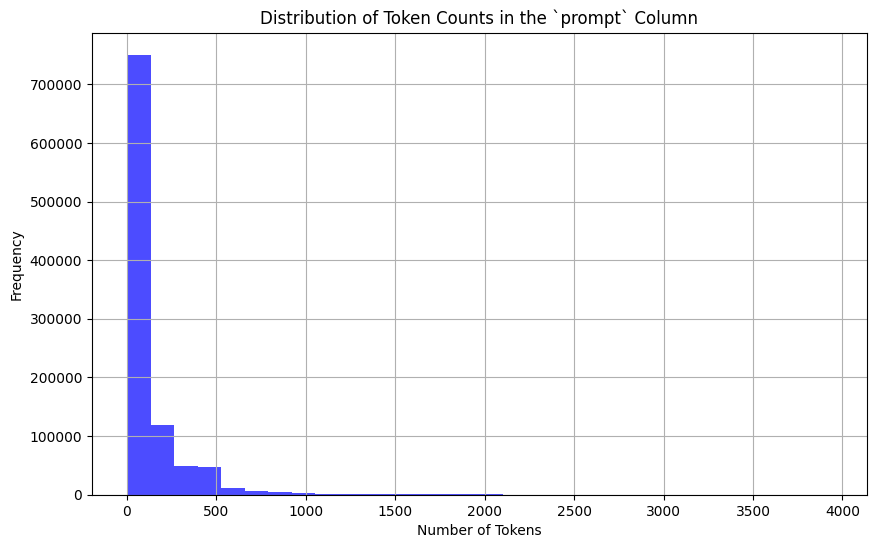

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(token_counts, bins=30, color='blue', alpha=0.7)
plt.title('Distribution of Token Counts in the `prompt` Column')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [10]:
# Assuming filtered_dataset_with_tokens already has the 'num_tokens' column
token_counts = dataset_with_tokens['length']

# Count the number of samples with more than 2500 tokens
count_over = sum(1 for count in token_counts if count > 64)

# Calculate the percentage of samples with more than 2500 tokens
total_samples = len(token_counts)
percentage_over = (count_over / total_samples) * 100

# Print the result
print(f"Percentage of samples with more than 2500 tokens: {percentage_over:.2f}%")

# Filter the dataset to keep only samples with fewer than 1024 tokens
filtered_dataset = dataset_with_tokens.filter(lambda example: example['length'] < 64, batched=False)

# Print the number of samples in the filtered dataset
print(f"Number of samples with fewer than 64 tokens: {len(filtered_dataset)}")


Percentage of samples with more than 2500 tokens: 44.50%
Number of samples with fewer than 64 tokens: 550433


In [11]:
filtered_dataset['prompt'][0]
pipe.generate_to_notebook(filtered_dataset['prompt'][0])

/home/alandao/.local/lib/python3.11/site-packages/torch/backends/cuda/__init__.py:342: FutureWarning: torch.backends.cuda.sdp_kernel() is deprecated. In the future, this context manager will be removed. Please see, torch.nn.attention.sdpa_kernel() for the new context manager, with updated signature.
  warnings.warn(


In [12]:
subset = filtered_dataset.select(range(10))
subset

Dataset({
    features: ['prompt', 'answer', 'length'],
    num_rows: 10
})

In [15]:
filtered_dataset
# Add an 'index' column to the dataset
index_column = list(range(filtered_dataset.num_rows))
filtered_dataset = filtered_dataset.add_column("index", index_column)
filtered_dataset

Flattening the indices:   0%|          | 0/550433 [00:00<?, ? examples/s]

Dataset({
    features: ['prompt', 'answer', 'length', 'index'],
    num_rows: 550433
})

In [17]:
# filtered_dataset.push_to_hub("jan-hq/prompt-voice")

Uploading the dataset shards:   0%|          | 0/2 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/276 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/276 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/369 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/jan-hq/prompt-voice/commit/d002a4e6df785630e3f680cbf70778c95d735feb', commit_message='Upload dataset', commit_description='', oid='d002a4e6df785630e3f680cbf70778c95d735feb', pr_url=None, pr_revision=None, pr_num=None)

# Single GPU

In [ ]:
from datasets import Audio, DatasetDict
import os
from huggingface_hub import HfFolder

# Import your pipeline setup
from whisperspeech.pipeline import Pipeline
pipe = Pipeline(s2a_ref='collabora/whisperspeech:s2a-q4-tiny-en+pl.model')

def generate_and_save_audio(text, index):
    audio_dir = 'audio'
    if not os.path.exists(audio_dir):
        os.makedirs(audio_dir)

    file_path = os.path.join(audio_dir, f'audio_{index}.wav')
    try:
        pipe.generate_to_file(file_path, text)
        return {'audio_path': file_path}  # Return a dictionary directly
    except Exception as e:
        print(f"Error generating audio for text: {text}, error: {e}")
        return {'audio_path': None}  # Ensure key exists even in case of error

def main(data_hf):
    data_hf = data_hf.map(
        lambda x, index: generate_and_save_audio(x['prompt'], index),
        with_indices=True,
        batched=False
    )
    return data_hf

if __name__ == "__main__":
    subset = filtered_dataset.select(range(1000))
    subset = main(subset)
    print(subset.column_names)  # Check columns after mapping

    if 'audio_path' in subset.column_names:
        subset = subset.cast_column("audio_path", Audio(sampling_rate=16000))
        print(subset[0]["audio_path"])  # Check the first audio entry
    else:
        print("audio_path column not found.")

# subset.push_to_hub("jan-hq/instruction-speech")

In [19]:
import os
pipe = Pipeline(s2a_ref='collabora/whisperspeech:s2a-q4-tiny-en+pl.model')

def generate_and_save_audio_batch(batch):
    audio_dir = 'audio-test'
    if not os.path.exists(audio_dir):
        os.makedirs(audio_dir)

    audio_paths = []
    for text, index in zip(batch['prompt'], batch['index']):
        file_path = os.path.join(audio_dir, f'audio_{index}.wav')
        try:
            pipe.generate_to_file(file_path, text)
            audio_paths.append(file_path)
        except Exception as e:
            print(f"Error generating audio for text: {text}, error: {e}")
            audio_paths.append(None)
        
    return {'audio_path': audio_paths}

def main(data_hf):
    data_hf = data_hf.map(
        generate_and_save_audio_batch,
        batched=True,
        batch_size=10
    )
    return data_hf

if __name__ == "__main__":
    subset = filtered_dataset.select(range(1000))  # Selecting a smaller subset for testing
    processed_subset = main(subset)
    print(processed_subset.column_names)  # Check columns after mapping

    if 'audio_path' in processed_subset.column_names:
        processed_subset = processed_subset.cast_column("audio_path", Audio(sampling_rate=16000))
        print(processed_subset[0]["audio_path"])  # Check the first audio entry
    else:
        print("audio_path column not found.")

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

KeyboardInterrupt: 

# Multi GPU

In [ ]:
# import torch
# import torch.distributed as dist
# from torch.nn.parallel import DistributedDataParallel as DDP
# from torch.utils.data.distributed import DistributedSampler
# from datasets import Audio, DatasetDict, load_dataset
# from torch.utils.data import DataLoader

# # Import your modified pipeline setup (now assuming DDP is handled internally)
# from whisperspeech.pipeline import Pipeline

# def setup(rank, world_size):
#     os.environ['MASTER_ADDR'] = 'localhost'
#     os.environ['MASTER_PORT'] = '12355'
#     dist.init_process_group("nccl", rank=rank, world_size=world_size)
#     torch.cuda.set_device(rank)

# def cleanup():
#     dist.destroy_process_group()

# def generate_and_save_audio(text, index, rank):
#     audio_dir = f'audio_{rank}'
#     if not os.path.exists(audio_dir):
#         os.makedirs(audio_dir)

#     file_path = os.path.join(audio_dir, f'audio_{index}.wav')
#     try:
#         pipe.generate_to_file(file_path, text)
#         return {'audio_path': file_path}
#     except Exception as e:
#         print(f"Error generating audio for text: {text}, error: {e}")
#         return {'audio_path': None}

# def main(rank, world_size):
#     setup(rank, world_size)
#     pipe = Pipeline(s2a_ref='collabora/whisperspeech:s2a-q4-tiny-en+pl.model').to(rank)
#     pipe = DDP(pipe, device_ids=[rank])

#     subset = filtered_dataset.select(range(10))
#     sampler = DistributedSampler(subset, num_replicas=world_size, rank=rank)
#     data_loader = DataLoader(subset, batch_size=10, sampler=sampler)

#     for i, batch in enumerate(data_loader):
#         result = generate_and_save_audio(batch['prompt'], i, rank)
#         # Handle result here, e.g., aggregating results, logging, etc.

#     cleanup()

# if __name__ == "__main__":
#     world_size = 4
#     torch.multiprocessing.spawn(main, args=(world_size,), nprocs=world_size)


# Process

In [10]:
subset = filtered_dataset.select(range(623))
# Step 2: Define the new column values
new_column_values = [f"audio/audio_{i}.wav" for i in range(len(subset))]

# Step 3: Add the new column to the dataset
subset = subset.add_column("audio_path", new_column_values)
subset

Flattening the indices:   0%|          | 0/623 [00:00<?, ? examples/s]

Dataset({
    features: ['prompt', 'answer', 'length', 'audio_path'],
    num_rows: 623
})

In [13]:
from datasets import Audio, DatasetDict
print(subset.column_names)  # Check columns after mapping

if 'audio_path' in subset.column_names:
    subset = subset.cast_column("audio_path", Audio(sampling_rate=24000))
    print(subset[0]["audio_path"])  # Check the first audio entry
else:
    print("audio_path column not found.")

subset.push_to_hub("jan-hq/instruction-speech")

['prompt', 'answer', 'length', 'audio_path']
{'path': 'audio/audio_0.wav', 'array': array([-5.18965935e-05, -1.26299210e-05, -2.21449354e-05, ...,
       -4.35770153e-06, -2.95290865e-05, -1.35192649e-05]), 'sampling_rate': 24000}


Uploading the dataset shards:   0%|          | 0/2 [00:00<?, ?it/s]

Map:   0%|          | 0/312 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/4 [00:00<?, ?ba/s]

Map:   0%|          | 0/311 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/4 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/420 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/jan-hq/instruction-speech/commit/1cfa36951c1264d8e61be7fbfff4575e723002e0', commit_message='Upload dataset', commit_description='', oid='1cfa36951c1264d8e61be7fbfff4575e723002e0', pr_url=None, pr_revision=None, pr_num=None)

In [10]:
!pip install -Uqq WhisperSpeech

In [11]:
import whisperspeech
print(whisperspeech.__file__)

/home/alandao/.local/lib/python3.11/site-packages/whisperspeech/__init__.py
